***
    
Demo EvoJAX for PINN (Physics-Informed Neural Network)
    
***

    Version: 2023-03-16
    
    Author : Nicholas Sung Wei Yong, Wong Jian Cheng, Ooi Chin Chun, Abhishek Gupta

    Contain:
    
    1. PINN for solving projectile motion equation
    
    2. Optimize PINN using xNES + NAG solver in the JAX framework
<!--        -  as described in Nicholas Sung Wei Yong, Jian Cheng Wong, Pao-Hsiung Chiu, Abhishek Gupta, Chinchun Ooi, Yew-Soon Ong
       "Neuroevolution Surpasses Stochastic Gradient Descent for Physics-Informed Neural Networks" arXiv preprint arXiv:2212.07624 (2022). -->

# Demo

In [1]:
# choose GPU
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

# import library
import numpy as np
import time

# import problem
from projectile import get_fitness, policy # Number of parameters: 260

xNES +NAG Solver

In [2]:
from jax import random, numpy as jnp
from jax.scipy.linalg import expm
from jax import jit, vmap
seed = 1
def xNES_NAG(f, x0, bs=20, lr=1e-3, sigma=1, maxtime=60, momentum_coeff=0.9, verbose=False):
    
    """ [xNES_NAG]
    Implemented baseline algo.: Exponential NES (xNES) as described in Glasmachers, Schaul, Sun, Wierstra and Schmidhuber (GECCO'10).
    Maximizes a function f. Returns (best solution found, corresponding fitness, etc.).
    
    Added Nesterov Accelerated Gradient (NAG) 
    """
    # Initialize random generator (+ seed)
    
    key, rng = random.split(random.PRNGKey(seed))
    
    # target search
    center = x0.copy()
    dim = len(x0)
    I = jnp.eye(dim)
    A = I * sigma
    momentum = jnp.zeros(dim)
    bestFitness = -jnp.inf    
    learningRate = lr     # a same learning rate apply to all updates (including mixture model coef.)
    batchSize = bs    
    bestFound = None
    bestFitness = -jnp.inf
    
    loss_ls = []
    t_training_ls = []
    
    @jit
    def project_sample(center, A, momentum, rng):
        center_proj = center + momentum_coeff * momentum
        # produce and evaluate samples
        key, rng = random.split(rng) # update random generator
        samples = random.normal(key, [batchSize, dim])
        samples_o = jnp.dot(samples, A) + center_proj
        return (samples, samples_o, rng)

    @jit
    def computeUtilities(fitnesses):
        l = jnp.argsort(fitnesses)
        ranks = jnp.argsort(l)
        L = fitnesses.size
        # smooth reshaping
        utilities = jnp.array([jnp.maximum(0., x) for x in jnp.log(L / 2. + 1.0) - jnp.log(L - jnp.array(ranks))])
        utilities /= sum(utilities)       # make the utilities sum to 1
        utilities -= 1. / L  # baseline
        return utilities

    @jit
    def update_parameters(center, A, momentum, utilities, samples):    
        # NAG parameter updates
        update_center = jnp.dot(A, jnp.dot(utilities, samples)) + momentum_coeff * momentum
        momentum = update_center
        # update center and variances
        center += update_center   
        covGradient = sum([u * (jnp.outer(s, s) - I) for (s, u) in zip(samples, utilities)])
        A = jnp.dot(A, expm(0.5 * learningRate * covGradient))
        return (center, A, momentum)
  
    
    # loop
    numEvals = 0
    t_training = 0
    while t_training <= maxtime:
        start = time.time()
        # do partial update (project into new center) & produce samples
        samples, samples_o, rng = project_sample(center, A, momentum, rng)        
        # evaluate sample fitness
        fitnesses = f(samples_o)
        # return best fitness and solution
        if max(fitnesses) > bestFitness:
            _bestFitness = jnp.argmax(fitnesses)
            bestFitness, bestFound = fitnesses[_bestFitness], samples_o[_bestFitness]
        # update no. evaluations 
        numEvals += batchSize
        # print progress
        if verbose:
            print ("Step %5d | lr %.1e | numEvals %7d  : %.3e   [Best: %.5e]" %(numEvals/batchSize, lr, numEvals,
                                                                                max(fitnesses), bestFitness))        
        
        # fitness shaping
        utilities = computeUtilities(fitnesses)
        # parameter updates
        center, A, momentum = update_parameters(center, A, momentum, utilities, samples)
        end = time.time()
        t_training += (end-start)
        
        t_training_ls.append(t_training)
        loss_ls.append(bestFitness)
        
    print("...\nRunning time: %d secs!" %(t_training))
    print("\nNo of iterations: %d iterations!" %(numEvals/batchSize))
    return bestFound, bestFitness, numEvals, t_training_ls, loss_ls


Training

In [3]:
# optimize PINN (no source -> xNES)
w0 = jnp.zeros(policy.num_params)
op_weight, op_fitness, evals, t_training_ls, loss_ls = xNES_NAG(get_fitness, w0, bs=50, lr=0.001, sigma=0.001, momentum_coeff=0.99, verbose=True)

Step     1 | lr 1.0e-03 | numEvals      50  : -1.177e+02   [Best: -1.17690e+02]
Step     2 | lr 1.0e-03 | numEvals     100  : -1.177e+02   [Best: -1.17690e+02]
Step     3 | lr 1.0e-03 | numEvals     150  : -1.177e+02   [Best: -1.17690e+02]
Step     4 | lr 1.0e-03 | numEvals     200  : -1.177e+02   [Best: -1.17690e+02]
Step     5 | lr 1.0e-03 | numEvals     250  : -1.177e+02   [Best: -1.17689e+02]
Step     6 | lr 1.0e-03 | numEvals     300  : -1.177e+02   [Best: -1.17689e+02]
Step     7 | lr 1.0e-03 | numEvals     350  : -1.177e+02   [Best: -1.17688e+02]
Step     8 | lr 1.0e-03 | numEvals     400  : -1.177e+02   [Best: -1.17687e+02]
Step     9 | lr 1.0e-03 | numEvals     450  : -1.177e+02   [Best: -1.17685e+02]
Step    10 | lr 1.0e-03 | numEvals     500  : -1.177e+02   [Best: -1.17682e+02]
Step    11 | lr 1.0e-03 | numEvals     550  : -1.177e+02   [Best: -1.17679e+02]
Step    12 | lr 1.0e-03 | numEvals     600  : -1.177e+02   [Best: -1.17674e+02]
Step    13 | lr 1.0e-03 | numEvals     6

Step   115 | lr 1.0e-03 | numEvals    5750  : -9.764e+01   [Best: -9.76403e+01]
Step   116 | lr 1.0e-03 | numEvals    5800  : -9.571e+01   [Best: -9.57125e+01]
Step   117 | lr 1.0e-03 | numEvals    5850  : -9.368e+01   [Best: -9.36809e+01]
Step   118 | lr 1.0e-03 | numEvals    5900  : -9.145e+01   [Best: -9.14489e+01]
Step   119 | lr 1.0e-03 | numEvals    5950  : -8.910e+01   [Best: -8.90980e+01]
Step   120 | lr 1.0e-03 | numEvals    6000  : -8.655e+01   [Best: -8.65491e+01]
Step   121 | lr 1.0e-03 | numEvals    6050  : -8.379e+01   [Best: -8.37892e+01]
Step   122 | lr 1.0e-03 | numEvals    6100  : -8.095e+01   [Best: -8.09532e+01]
Step   123 | lr 1.0e-03 | numEvals    6150  : -7.788e+01   [Best: -7.78808e+01]
Step   124 | lr 1.0e-03 | numEvals    6200  : -7.464e+01   [Best: -7.46437e+01]
Step   125 | lr 1.0e-03 | numEvals    6250  : -7.119e+01   [Best: -7.11908e+01]
Step   126 | lr 1.0e-03 | numEvals    6300  : -6.758e+01   [Best: -6.75833e+01]
Step   127 | lr 1.0e-03 | numEvals    63

Step   232 | lr 1.0e-03 | numEvals   11600  : -3.568e+01   [Best: -2.37558e+01]
Step   233 | lr 1.0e-03 | numEvals   11650  : -3.502e+01   [Best: -2.37558e+01]
Step   234 | lr 1.0e-03 | numEvals   11700  : -3.420e+01   [Best: -2.37558e+01]
Step   235 | lr 1.0e-03 | numEvals   11750  : -3.335e+01   [Best: -2.37558e+01]
Step   236 | lr 1.0e-03 | numEvals   11800  : -3.239e+01   [Best: -2.37558e+01]
Step   237 | lr 1.0e-03 | numEvals   11850  : -3.149e+01   [Best: -2.37558e+01]
Step   238 | lr 1.0e-03 | numEvals   11900  : -3.044e+01   [Best: -2.37558e+01]
Step   239 | lr 1.0e-03 | numEvals   11950  : -2.947e+01   [Best: -2.37558e+01]
Step   240 | lr 1.0e-03 | numEvals   12000  : -2.849e+01   [Best: -2.37558e+01]
Step   241 | lr 1.0e-03 | numEvals   12050  : -2.761e+01   [Best: -2.37558e+01]
Step   242 | lr 1.0e-03 | numEvals   12100  : -2.677e+01   [Best: -2.37558e+01]
Step   243 | lr 1.0e-03 | numEvals   12150  : -2.606e+01   [Best: -2.37558e+01]
Step   244 | lr 1.0e-03 | numEvals   122

Step   352 | lr 1.0e-03 | numEvals   17600  : -1.446e+01   [Best: -1.44590e+01]
Step   353 | lr 1.0e-03 | numEvals   17650  : -1.432e+01   [Best: -1.43216e+01]
Step   354 | lr 1.0e-03 | numEvals   17700  : -1.418e+01   [Best: -1.41817e+01]
Step   355 | lr 1.0e-03 | numEvals   17750  : -1.403e+01   [Best: -1.40347e+01]
Step   356 | lr 1.0e-03 | numEvals   17800  : -1.388e+01   [Best: -1.38752e+01]
Step   357 | lr 1.0e-03 | numEvals   17850  : -1.370e+01   [Best: -1.37027e+01]
Step   358 | lr 1.0e-03 | numEvals   17900  : -1.353e+01   [Best: -1.35261e+01]
Step   359 | lr 1.0e-03 | numEvals   17950  : -1.336e+01   [Best: -1.33577e+01]
Step   360 | lr 1.0e-03 | numEvals   18000  : -1.320e+01   [Best: -1.32006e+01]
Step   361 | lr 1.0e-03 | numEvals   18050  : -1.307e+01   [Best: -1.30748e+01]
Step   362 | lr 1.0e-03 | numEvals   18100  : -1.298e+01   [Best: -1.29838e+01]
Step   363 | lr 1.0e-03 | numEvals   18150  : -1.292e+01   [Best: -1.29181e+01]
Step   364 | lr 1.0e-03 | numEvals   182

Step   459 | lr 1.0e-03 | numEvals   22950  : -6.370e+00   [Best: -6.36997e+00]
Step   460 | lr 1.0e-03 | numEvals   23000  : -6.313e+00   [Best: -6.31317e+00]
Step   461 | lr 1.0e-03 | numEvals   23050  : -6.261e+00   [Best: -6.26126e+00]
Step   462 | lr 1.0e-03 | numEvals   23100  : -6.206e+00   [Best: -6.20641e+00]
Step   463 | lr 1.0e-03 | numEvals   23150  : -6.153e+00   [Best: -6.15283e+00]
Step   464 | lr 1.0e-03 | numEvals   23200  : -6.105e+00   [Best: -6.10540e+00]
Step   465 | lr 1.0e-03 | numEvals   23250  : -6.057e+00   [Best: -6.05684e+00]
Step   466 | lr 1.0e-03 | numEvals   23300  : -6.010e+00   [Best: -6.00972e+00]
Step   467 | lr 1.0e-03 | numEvals   23350  : -5.965e+00   [Best: -5.96482e+00]
Step   468 | lr 1.0e-03 | numEvals   23400  : -5.919e+00   [Best: -5.91894e+00]
Step   469 | lr 1.0e-03 | numEvals   23450  : -5.874e+00   [Best: -5.87371e+00]
Step   470 | lr 1.0e-03 | numEvals   23500  : -5.833e+00   [Best: -5.83285e+00]
Step   471 | lr 1.0e-03 | numEvals   235

Step   564 | lr 1.0e-03 | numEvals   28200  : -4.120e+00   [Best: -4.12006e+00]
Step   565 | lr 1.0e-03 | numEvals   28250  : -4.117e+00   [Best: -4.11667e+00]
Step   566 | lr 1.0e-03 | numEvals   28300  : -4.114e+00   [Best: -4.11405e+00]
Step   567 | lr 1.0e-03 | numEvals   28350  : -4.111e+00   [Best: -4.11118e+00]
Step   568 | lr 1.0e-03 | numEvals   28400  : -4.109e+00   [Best: -4.10881e+00]
Step   569 | lr 1.0e-03 | numEvals   28450  : -4.106e+00   [Best: -4.10622e+00]
Step   570 | lr 1.0e-03 | numEvals   28500  : -4.104e+00   [Best: -4.10447e+00]
Step   571 | lr 1.0e-03 | numEvals   28550  : -4.103e+00   [Best: -4.10293e+00]
Step   572 | lr 1.0e-03 | numEvals   28600  : -4.101e+00   [Best: -4.10092e+00]
Step   573 | lr 1.0e-03 | numEvals   28650  : -4.100e+00   [Best: -4.09962e+00]
Step   574 | lr 1.0e-03 | numEvals   28700  : -4.098e+00   [Best: -4.09841e+00]
Step   575 | lr 1.0e-03 | numEvals   28750  : -4.096e+00   [Best: -4.09618e+00]
Step   576 | lr 1.0e-03 | numEvals   288

Step   667 | lr 1.0e-03 | numEvals   33350  : -4.249e+00   [Best: -4.09315e+00]
Step   668 | lr 1.0e-03 | numEvals   33400  : -4.249e+00   [Best: -4.09315e+00]
Step   669 | lr 1.0e-03 | numEvals   33450  : -4.248e+00   [Best: -4.09315e+00]
Step   670 | lr 1.0e-03 | numEvals   33500  : -4.250e+00   [Best: -4.09315e+00]
Step   671 | lr 1.0e-03 | numEvals   33550  : -4.249e+00   [Best: -4.09315e+00]
Step   672 | lr 1.0e-03 | numEvals   33600  : -4.251e+00   [Best: -4.09315e+00]
Step   673 | lr 1.0e-03 | numEvals   33650  : -4.249e+00   [Best: -4.09315e+00]
Step   674 | lr 1.0e-03 | numEvals   33700  : -4.249e+00   [Best: -4.09315e+00]
Step   675 | lr 1.0e-03 | numEvals   33750  : -4.250e+00   [Best: -4.09315e+00]
Step   676 | lr 1.0e-03 | numEvals   33800  : -4.251e+00   [Best: -4.09315e+00]
Step   677 | lr 1.0e-03 | numEvals   33850  : -4.250e+00   [Best: -4.09315e+00]
Step   678 | lr 1.0e-03 | numEvals   33900  : -4.250e+00   [Best: -4.09315e+00]
Step   679 | lr 1.0e-03 | numEvals   339

Step   771 | lr 1.0e-03 | numEvals   38550  : -4.147e+00   [Best: -4.09315e+00]
Step   772 | lr 1.0e-03 | numEvals   38600  : -4.145e+00   [Best: -4.09315e+00]
Step   773 | lr 1.0e-03 | numEvals   38650  : -4.143e+00   [Best: -4.09315e+00]
Step   774 | lr 1.0e-03 | numEvals   38700  : -4.141e+00   [Best: -4.09315e+00]
Step   775 | lr 1.0e-03 | numEvals   38750  : -4.139e+00   [Best: -4.09315e+00]
Step   776 | lr 1.0e-03 | numEvals   38800  : -4.137e+00   [Best: -4.09315e+00]
Step   777 | lr 1.0e-03 | numEvals   38850  : -4.134e+00   [Best: -4.09315e+00]
Step   778 | lr 1.0e-03 | numEvals   38900  : -4.132e+00   [Best: -4.09315e+00]
Step   779 | lr 1.0e-03 | numEvals   38950  : -4.130e+00   [Best: -4.09315e+00]
Step   780 | lr 1.0e-03 | numEvals   39000  : -4.126e+00   [Best: -4.09315e+00]
Step   781 | lr 1.0e-03 | numEvals   39050  : -4.125e+00   [Best: -4.09315e+00]
Step   782 | lr 1.0e-03 | numEvals   39100  : -4.125e+00   [Best: -4.09315e+00]
Step   783 | lr 1.0e-03 | numEvals   391

Step   889 | lr 1.0e-03 | numEvals   44450  : -3.951e+00   [Best: -3.95079e+00]
Step   890 | lr 1.0e-03 | numEvals   44500  : -3.949e+00   [Best: -3.94896e+00]
Step   891 | lr 1.0e-03 | numEvals   44550  : -3.947e+00   [Best: -3.94694e+00]
Step   892 | lr 1.0e-03 | numEvals   44600  : -3.946e+00   [Best: -3.94630e+00]
Step   893 | lr 1.0e-03 | numEvals   44650  : -3.944e+00   [Best: -3.94423e+00]
Step   894 | lr 1.0e-03 | numEvals   44700  : -3.944e+00   [Best: -3.94371e+00]
Step   895 | lr 1.0e-03 | numEvals   44750  : -3.940e+00   [Best: -3.94006e+00]
Step   896 | lr 1.0e-03 | numEvals   44800  : -3.940e+00   [Best: -3.93989e+00]
Step   897 | lr 1.0e-03 | numEvals   44850  : -3.938e+00   [Best: -3.93844e+00]
Step   898 | lr 1.0e-03 | numEvals   44900  : -3.938e+00   [Best: -3.93792e+00]
Step   899 | lr 1.0e-03 | numEvals   44950  : -3.938e+00   [Best: -3.93792e+00]
Step   900 | lr 1.0e-03 | numEvals   45000  : -3.934e+00   [Best: -3.93416e+00]
Step   901 | lr 1.0e-03 | numEvals   450

Step  1007 | lr 1.0e-03 | numEvals   50350  : -3.919e+00   [Best: -3.89830e+00]
Step  1008 | lr 1.0e-03 | numEvals   50400  : -3.918e+00   [Best: -3.89830e+00]
Step  1009 | lr 1.0e-03 | numEvals   50450  : -3.920e+00   [Best: -3.89830e+00]
Step  1010 | lr 1.0e-03 | numEvals   50500  : -3.920e+00   [Best: -3.89830e+00]
Step  1011 | lr 1.0e-03 | numEvals   50550  : -3.920e+00   [Best: -3.89830e+00]
Step  1012 | lr 1.0e-03 | numEvals   50600  : -3.919e+00   [Best: -3.89830e+00]
Step  1013 | lr 1.0e-03 | numEvals   50650  : -3.920e+00   [Best: -3.89830e+00]
Step  1014 | lr 1.0e-03 | numEvals   50700  : -3.920e+00   [Best: -3.89830e+00]
Step  1015 | lr 1.0e-03 | numEvals   50750  : -3.920e+00   [Best: -3.89830e+00]
Step  1016 | lr 1.0e-03 | numEvals   50800  : -3.920e+00   [Best: -3.89830e+00]
Step  1017 | lr 1.0e-03 | numEvals   50850  : -3.919e+00   [Best: -3.89830e+00]
Step  1018 | lr 1.0e-03 | numEvals   50900  : -3.921e+00   [Best: -3.89830e+00]
Step  1019 | lr 1.0e-03 | numEvals   509

Step  1122 | lr 1.0e-03 | numEvals   56100  : -2.812e+00   [Best: -2.81171e+00]
Step  1123 | lr 1.0e-03 | numEvals   56150  : -2.792e+00   [Best: -2.79227e+00]
Step  1124 | lr 1.0e-03 | numEvals   56200  : -2.771e+00   [Best: -2.77149e+00]
Step  1125 | lr 1.0e-03 | numEvals   56250  : -2.752e+00   [Best: -2.75227e+00]
Step  1126 | lr 1.0e-03 | numEvals   56300  : -2.731e+00   [Best: -2.73079e+00]
Step  1127 | lr 1.0e-03 | numEvals   56350  : -2.712e+00   [Best: -2.71162e+00]
Step  1128 | lr 1.0e-03 | numEvals   56400  : -2.693e+00   [Best: -2.69259e+00]
Step  1129 | lr 1.0e-03 | numEvals   56450  : -2.672e+00   [Best: -2.67191e+00]
Step  1130 | lr 1.0e-03 | numEvals   56500  : -2.651e+00   [Best: -2.65084e+00]
Step  1131 | lr 1.0e-03 | numEvals   56550  : -2.631e+00   [Best: -2.63116e+00]
Step  1132 | lr 1.0e-03 | numEvals   56600  : -2.610e+00   [Best: -2.61006e+00]
Step  1133 | lr 1.0e-03 | numEvals   56650  : -2.589e+00   [Best: -2.58869e+00]
Step  1134 | lr 1.0e-03 | numEvals   567

Step  1238 | lr 1.0e-03 | numEvals   61900  : -2.021e+00   [Best: -2.02112e+00]
Step  1239 | lr 1.0e-03 | numEvals   61950  : -2.019e+00   [Best: -2.01887e+00]
Step  1240 | lr 1.0e-03 | numEvals   62000  : -2.019e+00   [Best: -2.01885e+00]
Step  1241 | lr 1.0e-03 | numEvals   62050  : -2.017e+00   [Best: -2.01683e+00]
Step  1242 | lr 1.0e-03 | numEvals   62100  : -2.014e+00   [Best: -2.01362e+00]
Step  1243 | lr 1.0e-03 | numEvals   62150  : -2.012e+00   [Best: -2.01212e+00]
Step  1244 | lr 1.0e-03 | numEvals   62200  : -2.011e+00   [Best: -2.01102e+00]
Step  1245 | lr 1.0e-03 | numEvals   62250  : -2.012e+00   [Best: -2.01102e+00]
Step  1246 | lr 1.0e-03 | numEvals   62300  : -2.007e+00   [Best: -2.00711e+00]
Step  1247 | lr 1.0e-03 | numEvals   62350  : -2.005e+00   [Best: -2.00494e+00]
Step  1248 | lr 1.0e-03 | numEvals   62400  : -2.005e+00   [Best: -2.00494e+00]
Step  1249 | lr 1.0e-03 | numEvals   62450  : -2.000e+00   [Best: -2.00001e+00]
Step  1250 | lr 1.0e-03 | numEvals   625

Step  1351 | lr 1.0e-03 | numEvals   67550  : -1.731e+00   [Best: -1.73103e+00]
Step  1352 | lr 1.0e-03 | numEvals   67600  : -1.727e+00   [Best: -1.72739e+00]
Step  1353 | lr 1.0e-03 | numEvals   67650  : -1.721e+00   [Best: -1.72074e+00]
Step  1354 | lr 1.0e-03 | numEvals   67700  : -1.719e+00   [Best: -1.71875e+00]
Step  1355 | lr 1.0e-03 | numEvals   67750  : -1.715e+00   [Best: -1.71525e+00]
Step  1356 | lr 1.0e-03 | numEvals   67800  : -1.707e+00   [Best: -1.70737e+00]
Step  1357 | lr 1.0e-03 | numEvals   67850  : -1.708e+00   [Best: -1.70737e+00]
Step  1358 | lr 1.0e-03 | numEvals   67900  : -1.702e+00   [Best: -1.70230e+00]
Step  1359 | lr 1.0e-03 | numEvals   67950  : -1.700e+00   [Best: -1.70016e+00]
Step  1360 | lr 1.0e-03 | numEvals   68000  : -1.694e+00   [Best: -1.69387e+00]
Step  1361 | lr 1.0e-03 | numEvals   68050  : -1.690e+00   [Best: -1.69046e+00]
Step  1362 | lr 1.0e-03 | numEvals   68100  : -1.684e+00   [Best: -1.68366e+00]
Step  1363 | lr 1.0e-03 | numEvals   681

Step  1458 | lr 1.0e-03 | numEvals   72900  : -1.196e+00   [Best: -1.19611e+00]
Step  1459 | lr 1.0e-03 | numEvals   72950  : -1.192e+00   [Best: -1.19244e+00]
Step  1460 | lr 1.0e-03 | numEvals   73000  : -1.187e+00   [Best: -1.18676e+00]
Step  1461 | lr 1.0e-03 | numEvals   73050  : -1.183e+00   [Best: -1.18258e+00]
Step  1462 | lr 1.0e-03 | numEvals   73100  : -1.182e+00   [Best: -1.18161e+00]
Step  1463 | lr 1.0e-03 | numEvals   73150  : -1.178e+00   [Best: -1.17809e+00]
Step  1464 | lr 1.0e-03 | numEvals   73200  : -1.175e+00   [Best: -1.17465e+00]
Step  1465 | lr 1.0e-03 | numEvals   73250  : -1.176e+00   [Best: -1.17465e+00]
Step  1466 | lr 1.0e-03 | numEvals   73300  : -1.173e+00   [Best: -1.17304e+00]
Step  1467 | lr 1.0e-03 | numEvals   73350  : -1.172e+00   [Best: -1.17180e+00]
Step  1468 | lr 1.0e-03 | numEvals   73400  : -1.172e+00   [Best: -1.17166e+00]
Step  1469 | lr 1.0e-03 | numEvals   73450  : -1.168e+00   [Best: -1.16788e+00]
Step  1470 | lr 1.0e-03 | numEvals   735

Step  1567 | lr 1.0e-03 | numEvals   78350  : -9.592e-01   [Best: -9.57472e-01]
Step  1568 | lr 1.0e-03 | numEvals   78400  : -9.563e-01   [Best: -9.56270e-01]
Step  1569 | lr 1.0e-03 | numEvals   78450  : -9.550e-01   [Best: -9.55020e-01]
Step  1570 | lr 1.0e-03 | numEvals   78500  : -9.529e-01   [Best: -9.52924e-01]
Step  1571 | lr 1.0e-03 | numEvals   78550  : -9.525e-01   [Best: -9.52468e-01]
Step  1572 | lr 1.0e-03 | numEvals   78600  : -9.517e-01   [Best: -9.51670e-01]
Step  1573 | lr 1.0e-03 | numEvals   78650  : -9.499e-01   [Best: -9.49870e-01]
Step  1574 | lr 1.0e-03 | numEvals   78700  : -9.492e-01   [Best: -9.49230e-01]
Step  1575 | lr 1.0e-03 | numEvals   78750  : -9.486e-01   [Best: -9.48573e-01]
Step  1576 | lr 1.0e-03 | numEvals   78800  : -9.462e-01   [Best: -9.46219e-01]
Step  1577 | lr 1.0e-03 | numEvals   78850  : -9.457e-01   [Best: -9.45668e-01]
Step  1578 | lr 1.0e-03 | numEvals   78900  : -9.436e-01   [Best: -9.43581e-01]
Step  1579 | lr 1.0e-03 | numEvals   789

Step  1683 | lr 1.0e-03 | numEvals   84150  : -8.242e-01   [Best: -8.06904e-01]
Step  1684 | lr 1.0e-03 | numEvals   84200  : -8.256e-01   [Best: -8.06904e-01]
Step  1685 | lr 1.0e-03 | numEvals   84250  : -8.276e-01   [Best: -8.06904e-01]
Step  1686 | lr 1.0e-03 | numEvals   84300  : -8.281e-01   [Best: -8.06904e-01]
Step  1687 | lr 1.0e-03 | numEvals   84350  : -8.220e-01   [Best: -8.06904e-01]
Step  1688 | lr 1.0e-03 | numEvals   84400  : -8.214e-01   [Best: -8.06904e-01]
Step  1689 | lr 1.0e-03 | numEvals   84450  : -8.129e-01   [Best: -8.06904e-01]
Step  1690 | lr 1.0e-03 | numEvals   84500  : -8.112e-01   [Best: -8.06904e-01]
Step  1691 | lr 1.0e-03 | numEvals   84550  : -8.014e-01   [Best: -8.01410e-01]
Step  1692 | lr 1.0e-03 | numEvals   84600  : -8.006e-01   [Best: -8.00576e-01]
Step  1693 | lr 1.0e-03 | numEvals   84650  : -7.989e-01   [Best: -7.98916e-01]
Step  1694 | lr 1.0e-03 | numEvals   84700  : -7.963e-01   [Best: -7.96263e-01]
Step  1695 | lr 1.0e-03 | numEvals   847

Step  1804 | lr 1.0e-03 | numEvals   90200  : -7.294e-01   [Best: -7.29415e-01]
Step  1805 | lr 1.0e-03 | numEvals   90250  : -7.300e-01   [Best: -7.29415e-01]
Step  1806 | lr 1.0e-03 | numEvals   90300  : -7.245e-01   [Best: -7.24505e-01]
Step  1807 | lr 1.0e-03 | numEvals   90350  : -7.251e-01   [Best: -7.24505e-01]
Step  1808 | lr 1.0e-03 | numEvals   90400  : -7.275e-01   [Best: -7.24505e-01]
Step  1809 | lr 1.0e-03 | numEvals   90450  : -7.244e-01   [Best: -7.24356e-01]
Step  1810 | lr 1.0e-03 | numEvals   90500  : -7.230e-01   [Best: -7.22990e-01]
Step  1811 | lr 1.0e-03 | numEvals   90550  : -7.214e-01   [Best: -7.21392e-01]
Step  1812 | lr 1.0e-03 | numEvals   90600  : -7.156e-01   [Best: -7.15554e-01]
Step  1813 | lr 1.0e-03 | numEvals   90650  : -7.185e-01   [Best: -7.15554e-01]
Step  1814 | lr 1.0e-03 | numEvals   90700  : -7.187e-01   [Best: -7.15554e-01]
Step  1815 | lr 1.0e-03 | numEvals   90750  : -7.177e-01   [Best: -7.15554e-01]
Step  1816 | lr 1.0e-03 | numEvals   908

Step  1922 | lr 1.0e-03 | numEvals   96100  : -6.458e-01   [Best: -6.45814e-01]
Step  1923 | lr 1.0e-03 | numEvals   96150  : -6.434e-01   [Best: -6.43435e-01]
Step  1924 | lr 1.0e-03 | numEvals   96200  : -6.429e-01   [Best: -6.42937e-01]
Step  1925 | lr 1.0e-03 | numEvals   96250  : -6.370e-01   [Best: -6.36991e-01]
Step  1926 | lr 1.0e-03 | numEvals   96300  : -6.367e-01   [Best: -6.36672e-01]
Step  1927 | lr 1.0e-03 | numEvals   96350  : -6.364e-01   [Best: -6.36362e-01]
Step  1928 | lr 1.0e-03 | numEvals   96400  : -6.308e-01   [Best: -6.30776e-01]
Step  1929 | lr 1.0e-03 | numEvals   96450  : -6.353e-01   [Best: -6.30776e-01]
Step  1930 | lr 1.0e-03 | numEvals   96500  : -6.334e-01   [Best: -6.30776e-01]
Step  1931 | lr 1.0e-03 | numEvals   96550  : -6.334e-01   [Best: -6.30776e-01]
Step  1932 | lr 1.0e-03 | numEvals   96600  : -6.330e-01   [Best: -6.30776e-01]
Step  1933 | lr 1.0e-03 | numEvals   96650  : -6.338e-01   [Best: -6.30776e-01]
Step  1934 | lr 1.0e-03 | numEvals   967

Step  2036 | lr 1.0e-03 | numEvals  101800  : -4.673e-01   [Best: -4.67269e-01]
Step  2037 | lr 1.0e-03 | numEvals  101850  : -4.635e-01   [Best: -4.63502e-01]
Step  2038 | lr 1.0e-03 | numEvals  101900  : -4.666e-01   [Best: -4.63502e-01]
Step  2039 | lr 1.0e-03 | numEvals  101950  : -4.616e-01   [Best: -4.61586e-01]
Step  2040 | lr 1.0e-03 | numEvals  102000  : -4.645e-01   [Best: -4.61586e-01]
Step  2041 | lr 1.0e-03 | numEvals  102050  : -4.574e-01   [Best: -4.57422e-01]
Step  2042 | lr 1.0e-03 | numEvals  102100  : -4.556e-01   [Best: -4.55625e-01]
Step  2043 | lr 1.0e-03 | numEvals  102150  : -4.534e-01   [Best: -4.53381e-01]
Step  2044 | lr 1.0e-03 | numEvals  102200  : -4.522e-01   [Best: -4.52170e-01]
Step  2045 | lr 1.0e-03 | numEvals  102250  : -4.466e-01   [Best: -4.46593e-01]
Step  2046 | lr 1.0e-03 | numEvals  102300  : -4.430e-01   [Best: -4.43044e-01]
Step  2047 | lr 1.0e-03 | numEvals  102350  : -4.394e-01   [Best: -4.39356e-01]
Step  2048 | lr 1.0e-03 | numEvals  1024

Step  2153 | lr 1.0e-03 | numEvals  107650  : -3.249e-01   [Best: -3.23283e-01]
Step  2154 | lr 1.0e-03 | numEvals  107700  : -3.229e-01   [Best: -3.22866e-01]
Step  2155 | lr 1.0e-03 | numEvals  107750  : -3.221e-01   [Best: -3.22142e-01]
Step  2156 | lr 1.0e-03 | numEvals  107800  : -3.182e-01   [Best: -3.18163e-01]
Step  2157 | lr 1.0e-03 | numEvals  107850  : -3.190e-01   [Best: -3.18163e-01]
Step  2158 | lr 1.0e-03 | numEvals  107900  : -3.175e-01   [Best: -3.17550e-01]
Step  2159 | lr 1.0e-03 | numEvals  107950  : -3.161e-01   [Best: -3.16104e-01]
Step  2160 | lr 1.0e-03 | numEvals  108000  : -3.166e-01   [Best: -3.16104e-01]
Step  2161 | lr 1.0e-03 | numEvals  108050  : -3.162e-01   [Best: -3.16104e-01]
Step  2162 | lr 1.0e-03 | numEvals  108100  : -3.133e-01   [Best: -3.13267e-01]
Step  2163 | lr 1.0e-03 | numEvals  108150  : -3.160e-01   [Best: -3.13267e-01]
Step  2164 | lr 1.0e-03 | numEvals  108200  : -3.149e-01   [Best: -3.13267e-01]
Step  2165 | lr 1.0e-03 | numEvals  1082

Step  2263 | lr 1.0e-03 | numEvals  113150  : -2.305e-01   [Best: -2.26225e-01]
Step  2264 | lr 1.0e-03 | numEvals  113200  : -2.261e-01   [Best: -2.26144e-01]
Step  2265 | lr 1.0e-03 | numEvals  113250  : -2.249e-01   [Best: -2.24931e-01]
Step  2266 | lr 1.0e-03 | numEvals  113300  : -2.237e-01   [Best: -2.23712e-01]
Step  2267 | lr 1.0e-03 | numEvals  113350  : -2.234e-01   [Best: -2.23394e-01]
Step  2268 | lr 1.0e-03 | numEvals  113400  : -2.216e-01   [Best: -2.21577e-01]
Step  2269 | lr 1.0e-03 | numEvals  113450  : -2.217e-01   [Best: -2.21577e-01]
Step  2270 | lr 1.0e-03 | numEvals  113500  : -2.215e-01   [Best: -2.21505e-01]
Step  2271 | lr 1.0e-03 | numEvals  113550  : -2.213e-01   [Best: -2.21302e-01]
Step  2272 | lr 1.0e-03 | numEvals  113600  : -2.181e-01   [Best: -2.18075e-01]
Step  2273 | lr 1.0e-03 | numEvals  113650  : -2.189e-01   [Best: -2.18075e-01]
Step  2274 | lr 1.0e-03 | numEvals  113700  : -2.133e-01   [Best: -2.13288e-01]
Step  2275 | lr 1.0e-03 | numEvals  1137

Step  2373 | lr 1.0e-03 | numEvals  118650  : -1.301e-01   [Best: -1.30118e-01]
Step  2374 | lr 1.0e-03 | numEvals  118700  : -1.288e-01   [Best: -1.28807e-01]
Step  2375 | lr 1.0e-03 | numEvals  118750  : -1.268e-01   [Best: -1.26838e-01]
Step  2376 | lr 1.0e-03 | numEvals  118800  : -1.256e-01   [Best: -1.25557e-01]
Step  2377 | lr 1.0e-03 | numEvals  118850  : -1.240e-01   [Best: -1.24025e-01]
Step  2378 | lr 1.0e-03 | numEvals  118900  : -1.215e-01   [Best: -1.21542e-01]
Step  2379 | lr 1.0e-03 | numEvals  118950  : -1.236e-01   [Best: -1.21542e-01]
Step  2380 | lr 1.0e-03 | numEvals  119000  : -1.251e-01   [Best: -1.21542e-01]
Step  2381 | lr 1.0e-03 | numEvals  119050  : -1.205e-01   [Best: -1.20514e-01]
Step  2382 | lr 1.0e-03 | numEvals  119100  : -1.192e-01   [Best: -1.19167e-01]
Step  2383 | lr 1.0e-03 | numEvals  119150  : -1.173e-01   [Best: -1.17285e-01]
Step  2384 | lr 1.0e-03 | numEvals  119200  : -1.167e-01   [Best: -1.16665e-01]
Step  2385 | lr 1.0e-03 | numEvals  1192

Step  2490 | lr 1.0e-03 | numEvals  124500  : -6.374e-02   [Best: -6.27419e-02]
Step  2491 | lr 1.0e-03 | numEvals  124550  : -6.233e-02   [Best: -6.23327e-02]
Step  2492 | lr 1.0e-03 | numEvals  124600  : -6.305e-02   [Best: -6.23327e-02]
Step  2493 | lr 1.0e-03 | numEvals  124650  : -6.232e-02   [Best: -6.23250e-02]
Step  2494 | lr 1.0e-03 | numEvals  124700  : -6.159e-02   [Best: -6.15870e-02]
Step  2495 | lr 1.0e-03 | numEvals  124750  : -6.269e-02   [Best: -6.15870e-02]
Step  2496 | lr 1.0e-03 | numEvals  124800  : -6.207e-02   [Best: -6.15870e-02]
Step  2497 | lr 1.0e-03 | numEvals  124850  : -6.111e-02   [Best: -6.11136e-02]
Step  2498 | lr 1.0e-03 | numEvals  124900  : -6.233e-02   [Best: -6.11136e-02]
Step  2499 | lr 1.0e-03 | numEvals  124950  : -6.177e-02   [Best: -6.11136e-02]
Step  2500 | lr 1.0e-03 | numEvals  125000  : -6.007e-02   [Best: -6.00730e-02]
Step  2501 | lr 1.0e-03 | numEvals  125050  : -6.054e-02   [Best: -6.00730e-02]
Step  2502 | lr 1.0e-03 | numEvals  1251

Step  2611 | lr 1.0e-03 | numEvals  130550  : -6.746e-02   [Best: -6.00730e-02]
Step  2612 | lr 1.0e-03 | numEvals  130600  : -6.964e-02   [Best: -6.00730e-02]
Step  2613 | lr 1.0e-03 | numEvals  130650  : -6.994e-02   [Best: -6.00730e-02]
Step  2614 | lr 1.0e-03 | numEvals  130700  : -7.271e-02   [Best: -6.00730e-02]
Step  2615 | lr 1.0e-03 | numEvals  130750  : -7.424e-02   [Best: -6.00730e-02]
Step  2616 | lr 1.0e-03 | numEvals  130800  : -7.227e-02   [Best: -6.00730e-02]
Step  2617 | lr 1.0e-03 | numEvals  130850  : -7.406e-02   [Best: -6.00730e-02]
Step  2618 | lr 1.0e-03 | numEvals  130900  : -7.440e-02   [Best: -6.00730e-02]
Step  2619 | lr 1.0e-03 | numEvals  130950  : -7.342e-02   [Best: -6.00730e-02]
Step  2620 | lr 1.0e-03 | numEvals  131000  : -7.302e-02   [Best: -6.00730e-02]
Step  2621 | lr 1.0e-03 | numEvals  131050  : -7.244e-02   [Best: -6.00730e-02]
Step  2622 | lr 1.0e-03 | numEvals  131100  : -7.122e-02   [Best: -6.00730e-02]
Step  2623 | lr 1.0e-03 | numEvals  1311

Step  2716 | lr 1.0e-03 | numEvals  135800  : -5.969e-02   [Best: -5.92347e-02]
Step  2717 | lr 1.0e-03 | numEvals  135850  : -5.879e-02   [Best: -5.87878e-02]
Step  2718 | lr 1.0e-03 | numEvals  135900  : -5.897e-02   [Best: -5.87878e-02]
Step  2719 | lr 1.0e-03 | numEvals  135950  : -5.853e-02   [Best: -5.85264e-02]
Step  2720 | lr 1.0e-03 | numEvals  136000  : -5.847e-02   [Best: -5.84664e-02]
Step  2721 | lr 1.0e-03 | numEvals  136050  : -5.891e-02   [Best: -5.84664e-02]
Step  2722 | lr 1.0e-03 | numEvals  136100  : -5.822e-02   [Best: -5.82242e-02]
Step  2723 | lr 1.0e-03 | numEvals  136150  : -5.828e-02   [Best: -5.82242e-02]
Step  2724 | lr 1.0e-03 | numEvals  136200  : -5.885e-02   [Best: -5.82242e-02]
Step  2725 | lr 1.0e-03 | numEvals  136250  : -5.939e-02   [Best: -5.82242e-02]
Step  2726 | lr 1.0e-03 | numEvals  136300  : -5.930e-02   [Best: -5.82242e-02]
Step  2727 | lr 1.0e-03 | numEvals  136350  : -5.862e-02   [Best: -5.82242e-02]
Step  2728 | lr 1.0e-03 | numEvals  1364

Step  2821 | lr 1.0e-03 | numEvals  141050  : -6.160e-02   [Best: -5.65956e-02]
Step  2822 | lr 1.0e-03 | numEvals  141100  : -6.174e-02   [Best: -5.65956e-02]
Step  2823 | lr 1.0e-03 | numEvals  141150  : -6.202e-02   [Best: -5.65956e-02]
Step  2824 | lr 1.0e-03 | numEvals  141200  : -6.185e-02   [Best: -5.65956e-02]
Step  2825 | lr 1.0e-03 | numEvals  141250  : -6.127e-02   [Best: -5.65956e-02]
Step  2826 | lr 1.0e-03 | numEvals  141300  : -6.051e-02   [Best: -5.65956e-02]
Step  2827 | lr 1.0e-03 | numEvals  141350  : -6.110e-02   [Best: -5.65956e-02]
Step  2828 | lr 1.0e-03 | numEvals  141400  : -5.896e-02   [Best: -5.65956e-02]
Step  2829 | lr 1.0e-03 | numEvals  141450  : -6.007e-02   [Best: -5.65956e-02]
Step  2830 | lr 1.0e-03 | numEvals  141500  : -5.972e-02   [Best: -5.65956e-02]
Step  2831 | lr 1.0e-03 | numEvals  141550  : -6.143e-02   [Best: -5.65956e-02]
Step  2832 | lr 1.0e-03 | numEvals  141600  : -6.085e-02   [Best: -5.65956e-02]
Step  2833 | lr 1.0e-03 | numEvals  1416

Step  2942 | lr 1.0e-03 | numEvals  147100  : -6.274e-02   [Best: -5.12029e-02]
Step  2943 | lr 1.0e-03 | numEvals  147150  : -6.246e-02   [Best: -5.12029e-02]
Step  2944 | lr 1.0e-03 | numEvals  147200  : -6.320e-02   [Best: -5.12029e-02]
Step  2945 | lr 1.0e-03 | numEvals  147250  : -6.166e-02   [Best: -5.12029e-02]
Step  2946 | lr 1.0e-03 | numEvals  147300  : -6.375e-02   [Best: -5.12029e-02]
Step  2947 | lr 1.0e-03 | numEvals  147350  : -6.440e-02   [Best: -5.12029e-02]
Step  2948 | lr 1.0e-03 | numEvals  147400  : -6.471e-02   [Best: -5.12029e-02]
Step  2949 | lr 1.0e-03 | numEvals  147450  : -6.150e-02   [Best: -5.12029e-02]
Step  2950 | lr 1.0e-03 | numEvals  147500  : -6.303e-02   [Best: -5.12029e-02]
Step  2951 | lr 1.0e-03 | numEvals  147550  : -6.127e-02   [Best: -5.12029e-02]
Step  2952 | lr 1.0e-03 | numEvals  147600  : -6.083e-02   [Best: -5.12029e-02]
Step  2953 | lr 1.0e-03 | numEvals  147650  : -6.010e-02   [Best: -5.12029e-02]
Step  2954 | lr 1.0e-03 | numEvals  1477

Step  3047 | lr 1.0e-03 | numEvals  152350  : -9.014e-02   [Best: -5.12029e-02]
Step  3048 | lr 1.0e-03 | numEvals  152400  : -8.955e-02   [Best: -5.12029e-02]
Step  3049 | lr 1.0e-03 | numEvals  152450  : -8.751e-02   [Best: -5.12029e-02]
Step  3050 | lr 1.0e-03 | numEvals  152500  : -8.622e-02   [Best: -5.12029e-02]
Step  3051 | lr 1.0e-03 | numEvals  152550  : -8.287e-02   [Best: -5.12029e-02]
Step  3052 | lr 1.0e-03 | numEvals  152600  : -8.156e-02   [Best: -5.12029e-02]
Step  3053 | lr 1.0e-03 | numEvals  152650  : -7.968e-02   [Best: -5.12029e-02]
Step  3054 | lr 1.0e-03 | numEvals  152700  : -7.846e-02   [Best: -5.12029e-02]
Step  3055 | lr 1.0e-03 | numEvals  152750  : -7.699e-02   [Best: -5.12029e-02]
Step  3056 | lr 1.0e-03 | numEvals  152800  : -7.400e-02   [Best: -5.12029e-02]
Step  3057 | lr 1.0e-03 | numEvals  152850  : -7.268e-02   [Best: -5.12029e-02]
Step  3058 | lr 1.0e-03 | numEvals  152900  : -7.046e-02   [Best: -5.12029e-02]
Step  3059 | lr 1.0e-03 | numEvals  1529

Step  3167 | lr 1.0e-03 | numEvals  158350  : -4.529e-02   [Best: -4.28689e-02]
Step  3168 | lr 1.0e-03 | numEvals  158400  : -4.109e-02   [Best: -4.10866e-02]
Step  3169 | lr 1.0e-03 | numEvals  158450  : -4.381e-02   [Best: -4.10866e-02]
Step  3170 | lr 1.0e-03 | numEvals  158500  : -4.303e-02   [Best: -4.10866e-02]
Step  3171 | lr 1.0e-03 | numEvals  158550  : -4.225e-02   [Best: -4.10866e-02]
Step  3172 | lr 1.0e-03 | numEvals  158600  : -4.069e-02   [Best: -4.06897e-02]
Step  3173 | lr 1.0e-03 | numEvals  158650  : -3.766e-02   [Best: -3.76551e-02]
Step  3174 | lr 1.0e-03 | numEvals  158700  : -3.743e-02   [Best: -3.74256e-02]
Step  3175 | lr 1.0e-03 | numEvals  158750  : -3.605e-02   [Best: -3.60532e-02]
Step  3176 | lr 1.0e-03 | numEvals  158800  : -3.717e-02   [Best: -3.60532e-02]
Step  3177 | lr 1.0e-03 | numEvals  158850  : -3.727e-02   [Best: -3.60532e-02]
Step  3178 | lr 1.0e-03 | numEvals  158900  : -3.922e-02   [Best: -3.60532e-02]
Step  3179 | lr 1.0e-03 | numEvals  1589

Step  3270 | lr 1.0e-03 | numEvals  163500  : -6.947e-02   [Best: -3.60532e-02]
Step  3271 | lr 1.0e-03 | numEvals  163550  : -6.973e-02   [Best: -3.60532e-02]
Step  3272 | lr 1.0e-03 | numEvals  163600  : -7.073e-02   [Best: -3.60532e-02]
Step  3273 | lr 1.0e-03 | numEvals  163650  : -6.993e-02   [Best: -3.60532e-02]
Step  3274 | lr 1.0e-03 | numEvals  163700  : -7.437e-02   [Best: -3.60532e-02]
Step  3275 | lr 1.0e-03 | numEvals  163750  : -7.686e-02   [Best: -3.60532e-02]
Step  3276 | lr 1.0e-03 | numEvals  163800  : -7.729e-02   [Best: -3.60532e-02]
Step  3277 | lr 1.0e-03 | numEvals  163850  : -7.337e-02   [Best: -3.60532e-02]
Step  3278 | lr 1.0e-03 | numEvals  163900  : -7.684e-02   [Best: -3.60532e-02]
Step  3279 | lr 1.0e-03 | numEvals  163950  : -7.632e-02   [Best: -3.60532e-02]
Step  3280 | lr 1.0e-03 | numEvals  164000  : -7.623e-02   [Best: -3.60532e-02]
Step  3281 | lr 1.0e-03 | numEvals  164050  : -7.325e-02   [Best: -3.60532e-02]
Step  3282 | lr 1.0e-03 | numEvals  1641

Step  3377 | lr 1.0e-03 | numEvals  168850  : -5.365e-02   [Best: -3.60532e-02]
Step  3378 | lr 1.0e-03 | numEvals  168900  : -5.741e-02   [Best: -3.60532e-02]
Step  3379 | lr 1.0e-03 | numEvals  168950  : -5.670e-02   [Best: -3.60532e-02]
Step  3380 | lr 1.0e-03 | numEvals  169000  : -6.001e-02   [Best: -3.60532e-02]
Step  3381 | lr 1.0e-03 | numEvals  169050  : -5.991e-02   [Best: -3.60532e-02]
Step  3382 | lr 1.0e-03 | numEvals  169100  : -6.443e-02   [Best: -3.60532e-02]
Step  3383 | lr 1.0e-03 | numEvals  169150  : -6.706e-02   [Best: -3.60532e-02]
Step  3384 | lr 1.0e-03 | numEvals  169200  : -7.297e-02   [Best: -3.60532e-02]
Step  3385 | lr 1.0e-03 | numEvals  169250  : -7.571e-02   [Best: -3.60532e-02]
Step  3386 | lr 1.0e-03 | numEvals  169300  : -7.986e-02   [Best: -3.60532e-02]
Step  3387 | lr 1.0e-03 | numEvals  169350  : -8.026e-02   [Best: -3.60532e-02]
Step  3388 | lr 1.0e-03 | numEvals  169400  : -8.466e-02   [Best: -3.60532e-02]
Step  3389 | lr 1.0e-03 | numEvals  1694

Step  3482 | lr 1.0e-03 | numEvals  174100  : -7.345e-02   [Best: -3.60532e-02]
Step  3483 | lr 1.0e-03 | numEvals  174150  : -7.239e-02   [Best: -3.60532e-02]
Step  3484 | lr 1.0e-03 | numEvals  174200  : -7.286e-02   [Best: -3.60532e-02]
Step  3485 | lr 1.0e-03 | numEvals  174250  : -7.209e-02   [Best: -3.60532e-02]
Step  3486 | lr 1.0e-03 | numEvals  174300  : -6.801e-02   [Best: -3.60532e-02]
Step  3487 | lr 1.0e-03 | numEvals  174350  : -6.798e-02   [Best: -3.60532e-02]
Step  3488 | lr 1.0e-03 | numEvals  174400  : -6.820e-02   [Best: -3.60532e-02]
Step  3489 | lr 1.0e-03 | numEvals  174450  : -6.991e-02   [Best: -3.60532e-02]
Step  3490 | lr 1.0e-03 | numEvals  174500  : -6.776e-02   [Best: -3.60532e-02]
Step  3491 | lr 1.0e-03 | numEvals  174550  : -7.043e-02   [Best: -3.60532e-02]
Step  3492 | lr 1.0e-03 | numEvals  174600  : -7.030e-02   [Best: -3.60532e-02]
Step  3493 | lr 1.0e-03 | numEvals  174650  : -7.035e-02   [Best: -3.60532e-02]
Step  3494 | lr 1.0e-03 | numEvals  1747

Step  3604 | lr 1.0e-03 | numEvals  180200  : -1.076e-01   [Best: -3.60532e-02]
Step  3605 | lr 1.0e-03 | numEvals  180250  : -1.036e-01   [Best: -3.60532e-02]
Step  3606 | lr 1.0e-03 | numEvals  180300  : -1.037e-01   [Best: -3.60532e-02]
Step  3607 | lr 1.0e-03 | numEvals  180350  : -1.030e-01   [Best: -3.60532e-02]
Step  3608 | lr 1.0e-03 | numEvals  180400  : -1.016e-01   [Best: -3.60532e-02]
Step  3609 | lr 1.0e-03 | numEvals  180450  : -1.050e-01   [Best: -3.60532e-02]
Step  3610 | lr 1.0e-03 | numEvals  180500  : -1.066e-01   [Best: -3.60532e-02]
Step  3611 | lr 1.0e-03 | numEvals  180550  : -1.077e-01   [Best: -3.60532e-02]
Step  3612 | lr 1.0e-03 | numEvals  180600  : -1.091e-01   [Best: -3.60532e-02]
Step  3613 | lr 1.0e-03 | numEvals  180650  : -1.099e-01   [Best: -3.60532e-02]
Step  3614 | lr 1.0e-03 | numEvals  180700  : -1.089e-01   [Best: -3.60532e-02]
Step  3615 | lr 1.0e-03 | numEvals  180750  : -1.136e-01   [Best: -3.60532e-02]
Step  3616 | lr 1.0e-03 | numEvals  1808

Step  3725 | lr 1.0e-03 | numEvals  186250  : -1.465e-01   [Best: -3.60532e-02]
Step  3726 | lr 1.0e-03 | numEvals  186300  : -1.497e-01   [Best: -3.60532e-02]
Step  3727 | lr 1.0e-03 | numEvals  186350  : -1.522e-01   [Best: -3.60532e-02]
Step  3728 | lr 1.0e-03 | numEvals  186400  : -1.522e-01   [Best: -3.60532e-02]
Step  3729 | lr 1.0e-03 | numEvals  186450  : -1.560e-01   [Best: -3.60532e-02]
Step  3730 | lr 1.0e-03 | numEvals  186500  : -1.560e-01   [Best: -3.60532e-02]
Step  3731 | lr 1.0e-03 | numEvals  186550  : -1.542e-01   [Best: -3.60532e-02]
Step  3732 | lr 1.0e-03 | numEvals  186600  : -1.557e-01   [Best: -3.60532e-02]
Step  3733 | lr 1.0e-03 | numEvals  186650  : -1.508e-01   [Best: -3.60532e-02]
Step  3734 | lr 1.0e-03 | numEvals  186700  : -1.492e-01   [Best: -3.60532e-02]
Step  3735 | lr 1.0e-03 | numEvals  186750  : -1.449e-01   [Best: -3.60532e-02]
Step  3736 | lr 1.0e-03 | numEvals  186800  : -1.426e-01   [Best: -3.60532e-02]
Step  3737 | lr 1.0e-03 | numEvals  1868

Step  3831 | lr 1.0e-03 | numEvals  191550  : -9.798e-02   [Best: -3.60532e-02]
Step  3832 | lr 1.0e-03 | numEvals  191600  : -9.250e-02   [Best: -3.60532e-02]
Step  3833 | lr 1.0e-03 | numEvals  191650  : -9.112e-02   [Best: -3.60532e-02]
Step  3834 | lr 1.0e-03 | numEvals  191700  : -8.799e-02   [Best: -3.60532e-02]
Step  3835 | lr 1.0e-03 | numEvals  191750  : -8.517e-02   [Best: -3.60532e-02]
Step  3836 | lr 1.0e-03 | numEvals  191800  : -8.650e-02   [Best: -3.60532e-02]
Step  3837 | lr 1.0e-03 | numEvals  191850  : -8.563e-02   [Best: -3.60532e-02]
Step  3838 | lr 1.0e-03 | numEvals  191900  : -8.383e-02   [Best: -3.60532e-02]
Step  3839 | lr 1.0e-03 | numEvals  191950  : -8.410e-02   [Best: -3.60532e-02]
Step  3840 | lr 1.0e-03 | numEvals  192000  : -8.422e-02   [Best: -3.60532e-02]
Step  3841 | lr 1.0e-03 | numEvals  192050  : -8.360e-02   [Best: -3.60532e-02]
Step  3842 | lr 1.0e-03 | numEvals  192100  : -8.502e-02   [Best: -3.60532e-02]
Step  3843 | lr 1.0e-03 | numEvals  1921

Step  3935 | lr 1.0e-03 | numEvals  196750  : -7.710e-02   [Best: -3.60532e-02]
Step  3936 | lr 1.0e-03 | numEvals  196800  : -7.516e-02   [Best: -3.60532e-02]
Step  3937 | lr 1.0e-03 | numEvals  196850  : -7.328e-02   [Best: -3.60532e-02]
Step  3938 | lr 1.0e-03 | numEvals  196900  : -7.054e-02   [Best: -3.60532e-02]
Step  3939 | lr 1.0e-03 | numEvals  196950  : -6.862e-02   [Best: -3.60532e-02]
Step  3940 | lr 1.0e-03 | numEvals  197000  : -6.604e-02   [Best: -3.60532e-02]
Step  3941 | lr 1.0e-03 | numEvals  197050  : -6.407e-02   [Best: -3.60532e-02]
Step  3942 | lr 1.0e-03 | numEvals  197100  : -6.256e-02   [Best: -3.60532e-02]
Step  3943 | lr 1.0e-03 | numEvals  197150  : -6.045e-02   [Best: -3.60532e-02]
Step  3944 | lr 1.0e-03 | numEvals  197200  : -5.878e-02   [Best: -3.60532e-02]
Step  3945 | lr 1.0e-03 | numEvals  197250  : -5.941e-02   [Best: -3.60532e-02]
Step  3946 | lr 1.0e-03 | numEvals  197300  : -6.173e-02   [Best: -3.60532e-02]
Step  3947 | lr 1.0e-03 | numEvals  1973

Step  4039 | lr 1.0e-03 | numEvals  201950  : -6.443e-02   [Best: -3.60532e-02]
Step  4040 | lr 1.0e-03 | numEvals  202000  : -6.422e-02   [Best: -3.60532e-02]
Step  4041 | lr 1.0e-03 | numEvals  202050  : -6.377e-02   [Best: -3.60532e-02]
Step  4042 | lr 1.0e-03 | numEvals  202100  : -6.364e-02   [Best: -3.60532e-02]
Step  4043 | lr 1.0e-03 | numEvals  202150  : -6.303e-02   [Best: -3.60532e-02]
Step  4044 | lr 1.0e-03 | numEvals  202200  : -6.360e-02   [Best: -3.60532e-02]
Step  4045 | lr 1.0e-03 | numEvals  202250  : -6.277e-02   [Best: -3.60532e-02]
Step  4046 | lr 1.0e-03 | numEvals  202300  : -5.878e-02   [Best: -3.60532e-02]
Step  4047 | lr 1.0e-03 | numEvals  202350  : -5.983e-02   [Best: -3.60532e-02]
Step  4048 | lr 1.0e-03 | numEvals  202400  : -5.869e-02   [Best: -3.60532e-02]
Step  4049 | lr 1.0e-03 | numEvals  202450  : -5.838e-02   [Best: -3.60532e-02]
Step  4050 | lr 1.0e-03 | numEvals  202500  : -5.667e-02   [Best: -3.60532e-02]
Step  4051 | lr 1.0e-03 | numEvals  2025

Step  4162 | lr 1.0e-03 | numEvals  208100  : -5.828e-02   [Best: -3.60532e-02]
Step  4163 | lr 1.0e-03 | numEvals  208150  : -5.978e-02   [Best: -3.60532e-02]
Step  4164 | lr 1.0e-03 | numEvals  208200  : -6.044e-02   [Best: -3.60532e-02]
Step  4165 | lr 1.0e-03 | numEvals  208250  : -5.790e-02   [Best: -3.60532e-02]
Step  4166 | lr 1.0e-03 | numEvals  208300  : -5.722e-02   [Best: -3.60532e-02]
Step  4167 | lr 1.0e-03 | numEvals  208350  : -5.705e-02   [Best: -3.60532e-02]
Step  4168 | lr 1.0e-03 | numEvals  208400  : -5.476e-02   [Best: -3.60532e-02]
Step  4169 | lr 1.0e-03 | numEvals  208450  : -5.468e-02   [Best: -3.60532e-02]
Step  4170 | lr 1.0e-03 | numEvals  208500  : -4.941e-02   [Best: -3.60532e-02]
Step  4171 | lr 1.0e-03 | numEvals  208550  : -4.578e-02   [Best: -3.60532e-02]
Step  4172 | lr 1.0e-03 | numEvals  208600  : -4.505e-02   [Best: -3.60532e-02]
Step  4173 | lr 1.0e-03 | numEvals  208650  : -4.355e-02   [Best: -3.60532e-02]
Step  4174 | lr 1.0e-03 | numEvals  2087

Step  4282 | lr 1.0e-03 | numEvals  214100  : -4.456e-02   [Best: -2.27784e-02]
Step  4283 | lr 1.0e-03 | numEvals  214150  : -4.558e-02   [Best: -2.27784e-02]
Step  4284 | lr 1.0e-03 | numEvals  214200  : -4.488e-02   [Best: -2.27784e-02]
Step  4285 | lr 1.0e-03 | numEvals  214250  : -4.345e-02   [Best: -2.27784e-02]
Step  4286 | lr 1.0e-03 | numEvals  214300  : -4.379e-02   [Best: -2.27784e-02]
Step  4287 | lr 1.0e-03 | numEvals  214350  : -4.339e-02   [Best: -2.27784e-02]
Step  4288 | lr 1.0e-03 | numEvals  214400  : -4.107e-02   [Best: -2.27784e-02]
Step  4289 | lr 1.0e-03 | numEvals  214450  : -4.196e-02   [Best: -2.27784e-02]
Step  4290 | lr 1.0e-03 | numEvals  214500  : -4.067e-02   [Best: -2.27784e-02]
Step  4291 | lr 1.0e-03 | numEvals  214550  : -4.091e-02   [Best: -2.27784e-02]
Step  4292 | lr 1.0e-03 | numEvals  214600  : -4.106e-02   [Best: -2.27784e-02]
Step  4293 | lr 1.0e-03 | numEvals  214650  : -4.169e-02   [Best: -2.27784e-02]
Step  4294 | lr 1.0e-03 | numEvals  2147

Step  4387 | lr 1.0e-03 | numEvals  219350  : -6.588e-02   [Best: -2.27784e-02]
Step  4388 | lr 1.0e-03 | numEvals  219400  : -6.714e-02   [Best: -2.27784e-02]
Step  4389 | lr 1.0e-03 | numEvals  219450  : -6.497e-02   [Best: -2.27784e-02]
Step  4390 | lr 1.0e-03 | numEvals  219500  : -6.532e-02   [Best: -2.27784e-02]
Step  4391 | lr 1.0e-03 | numEvals  219550  : -6.308e-02   [Best: -2.27784e-02]
Step  4392 | lr 1.0e-03 | numEvals  219600  : -6.126e-02   [Best: -2.27784e-02]
Step  4393 | lr 1.0e-03 | numEvals  219650  : -6.039e-02   [Best: -2.27784e-02]
Step  4394 | lr 1.0e-03 | numEvals  219700  : -5.802e-02   [Best: -2.27784e-02]
Step  4395 | lr 1.0e-03 | numEvals  219750  : -5.371e-02   [Best: -2.27784e-02]
Step  4396 | lr 1.0e-03 | numEvals  219800  : -5.090e-02   [Best: -2.27784e-02]
Step  4397 | lr 1.0e-03 | numEvals  219850  : -4.947e-02   [Best: -2.27784e-02]
Step  4398 | lr 1.0e-03 | numEvals  219900  : -4.739e-02   [Best: -2.27784e-02]
Step  4399 | lr 1.0e-03 | numEvals  2199

Step  4508 | lr 1.0e-03 | numEvals  225400  : -4.892e-02   [Best: -2.27784e-02]
Step  4509 | lr 1.0e-03 | numEvals  225450  : -5.093e-02   [Best: -2.27784e-02]
Step  4510 | lr 1.0e-03 | numEvals  225500  : -4.679e-02   [Best: -2.27784e-02]
Step  4511 | lr 1.0e-03 | numEvals  225550  : -4.844e-02   [Best: -2.27784e-02]
Step  4512 | lr 1.0e-03 | numEvals  225600  : -4.754e-02   [Best: -2.27784e-02]
Step  4513 | lr 1.0e-03 | numEvals  225650  : -4.863e-02   [Best: -2.27784e-02]
Step  4514 | lr 1.0e-03 | numEvals  225700  : -4.685e-02   [Best: -2.27784e-02]
Step  4515 | lr 1.0e-03 | numEvals  225750  : -4.854e-02   [Best: -2.27784e-02]
Step  4516 | lr 1.0e-03 | numEvals  225800  : -4.704e-02   [Best: -2.27784e-02]
Step  4517 | lr 1.0e-03 | numEvals  225850  : -4.791e-02   [Best: -2.27784e-02]
Step  4518 | lr 1.0e-03 | numEvals  225900  : -4.911e-02   [Best: -2.27784e-02]
Step  4519 | lr 1.0e-03 | numEvals  225950  : -4.770e-02   [Best: -2.27784e-02]
Step  4520 | lr 1.0e-03 | numEvals  2260

Step  4613 | lr 1.0e-03 | numEvals  230650  : -5.118e-02   [Best: -2.27784e-02]
Step  4614 | lr 1.0e-03 | numEvals  230700  : -4.843e-02   [Best: -2.27784e-02]
Step  4615 | lr 1.0e-03 | numEvals  230750  : -4.510e-02   [Best: -2.27784e-02]
Step  4616 | lr 1.0e-03 | numEvals  230800  : -4.568e-02   [Best: -2.27784e-02]
Step  4617 | lr 1.0e-03 | numEvals  230850  : -4.359e-02   [Best: -2.27784e-02]
Step  4618 | lr 1.0e-03 | numEvals  230900  : -4.171e-02   [Best: -2.27784e-02]
Step  4619 | lr 1.0e-03 | numEvals  230950  : -4.081e-02   [Best: -2.27784e-02]
Step  4620 | lr 1.0e-03 | numEvals  231000  : -3.998e-02   [Best: -2.27784e-02]
Step  4621 | lr 1.0e-03 | numEvals  231050  : -3.757e-02   [Best: -2.27784e-02]
Step  4622 | lr 1.0e-03 | numEvals  231100  : -3.620e-02   [Best: -2.27784e-02]
Step  4623 | lr 1.0e-03 | numEvals  231150  : -3.580e-02   [Best: -2.27784e-02]
Step  4624 | lr 1.0e-03 | numEvals  231200  : -3.345e-02   [Best: -2.27784e-02]
Step  4625 | lr 1.0e-03 | numEvals  2312

Step  4718 | lr 1.0e-03 | numEvals  235900  : -3.616e-02   [Best: -2.27784e-02]
Step  4719 | lr 1.0e-03 | numEvals  235950  : -3.678e-02   [Best: -2.27784e-02]
Step  4720 | lr 1.0e-03 | numEvals  236000  : -3.795e-02   [Best: -2.27784e-02]
Step  4721 | lr 1.0e-03 | numEvals  236050  : -3.570e-02   [Best: -2.27784e-02]
Step  4722 | lr 1.0e-03 | numEvals  236100  : -3.661e-02   [Best: -2.27784e-02]
Step  4723 | lr 1.0e-03 | numEvals  236150  : -3.783e-02   [Best: -2.27784e-02]
Step  4724 | lr 1.0e-03 | numEvals  236200  : -3.426e-02   [Best: -2.27784e-02]
Step  4725 | lr 1.0e-03 | numEvals  236250  : -3.271e-02   [Best: -2.27784e-02]
Step  4726 | lr 1.0e-03 | numEvals  236300  : -3.344e-02   [Best: -2.27784e-02]
Step  4727 | lr 1.0e-03 | numEvals  236350  : -2.919e-02   [Best: -2.27784e-02]
Step  4728 | lr 1.0e-03 | numEvals  236400  : -3.032e-02   [Best: -2.27784e-02]
Step  4729 | lr 1.0e-03 | numEvals  236450  : -2.792e-02   [Best: -2.27784e-02]
Step  4730 | lr 1.0e-03 | numEvals  2365

Step  4838 | lr 1.0e-03 | numEvals  241900  : -3.684e-02   [Best: -2.27784e-02]
Step  4839 | lr 1.0e-03 | numEvals  241950  : -3.982e-02   [Best: -2.27784e-02]
Step  4840 | lr 1.0e-03 | numEvals  242000  : -3.873e-02   [Best: -2.27784e-02]
Step  4841 | lr 1.0e-03 | numEvals  242050  : -3.817e-02   [Best: -2.27784e-02]
Step  4842 | lr 1.0e-03 | numEvals  242100  : -3.952e-02   [Best: -2.27784e-02]
Step  4843 | lr 1.0e-03 | numEvals  242150  : -4.111e-02   [Best: -2.27784e-02]
Step  4844 | lr 1.0e-03 | numEvals  242200  : -4.268e-02   [Best: -2.27784e-02]
Step  4845 | lr 1.0e-03 | numEvals  242250  : -4.360e-02   [Best: -2.27784e-02]
Step  4846 | lr 1.0e-03 | numEvals  242300  : -4.267e-02   [Best: -2.27784e-02]
Step  4847 | lr 1.0e-03 | numEvals  242350  : -4.242e-02   [Best: -2.27784e-02]
Step  4848 | lr 1.0e-03 | numEvals  242400  : -4.357e-02   [Best: -2.27784e-02]
Step  4849 | lr 1.0e-03 | numEvals  242450  : -4.466e-02   [Best: -2.27784e-02]
Step  4850 | lr 1.0e-03 | numEvals  2425

Step  4943 | lr 1.0e-03 | numEvals  247150  : -2.863e-02   [Best: -2.27784e-02]
Step  4944 | lr 1.0e-03 | numEvals  247200  : -2.696e-02   [Best: -2.27784e-02]
Step  4945 | lr 1.0e-03 | numEvals  247250  : -2.957e-02   [Best: -2.27784e-02]
Step  4946 | lr 1.0e-03 | numEvals  247300  : -2.834e-02   [Best: -2.27784e-02]
Step  4947 | lr 1.0e-03 | numEvals  247350  : -2.792e-02   [Best: -2.27784e-02]
Step  4948 | lr 1.0e-03 | numEvals  247400  : -2.870e-02   [Best: -2.27784e-02]
Step  4949 | lr 1.0e-03 | numEvals  247450  : -2.960e-02   [Best: -2.27784e-02]
Step  4950 | lr 1.0e-03 | numEvals  247500  : -2.926e-02   [Best: -2.27784e-02]
Step  4951 | lr 1.0e-03 | numEvals  247550  : -2.918e-02   [Best: -2.27784e-02]
Step  4952 | lr 1.0e-03 | numEvals  247600  : -2.898e-02   [Best: -2.27784e-02]
Step  4953 | lr 1.0e-03 | numEvals  247650  : -2.751e-02   [Best: -2.27784e-02]
Step  4954 | lr 1.0e-03 | numEvals  247700  : -2.867e-02   [Best: -2.27784e-02]
Step  4955 | lr 1.0e-03 | numEvals  2477

Step  5046 | lr 1.0e-03 | numEvals  252300  : -2.631e-02   [Best: -1.87743e-02]
Step  5047 | lr 1.0e-03 | numEvals  252350  : -2.474e-02   [Best: -1.87743e-02]
Step  5048 | lr 1.0e-03 | numEvals  252400  : -2.390e-02   [Best: -1.87743e-02]
Step  5049 | lr 1.0e-03 | numEvals  252450  : -2.294e-02   [Best: -1.87743e-02]
Step  5050 | lr 1.0e-03 | numEvals  252500  : -2.359e-02   [Best: -1.87743e-02]
Step  5051 | lr 1.0e-03 | numEvals  252550  : -2.382e-02   [Best: -1.87743e-02]
Step  5052 | lr 1.0e-03 | numEvals  252600  : -2.350e-02   [Best: -1.87743e-02]
Step  5053 | lr 1.0e-03 | numEvals  252650  : -2.347e-02   [Best: -1.87743e-02]
Step  5054 | lr 1.0e-03 | numEvals  252700  : -2.449e-02   [Best: -1.87743e-02]
Step  5055 | lr 1.0e-03 | numEvals  252750  : -2.207e-02   [Best: -1.87743e-02]
Step  5056 | lr 1.0e-03 | numEvals  252800  : -2.036e-02   [Best: -1.87743e-02]
Step  5057 | lr 1.0e-03 | numEvals  252850  : -2.045e-02   [Best: -1.87743e-02]
Step  5058 | lr 1.0e-03 | numEvals  2529

Step  5151 | lr 1.0e-03 | numEvals  257550  : -3.711e-02   [Best: -1.83267e-02]
Step  5152 | lr 1.0e-03 | numEvals  257600  : -3.664e-02   [Best: -1.83267e-02]
Step  5153 | lr 1.0e-03 | numEvals  257650  : -3.501e-02   [Best: -1.83267e-02]
Step  5154 | lr 1.0e-03 | numEvals  257700  : -3.426e-02   [Best: -1.83267e-02]
Step  5155 | lr 1.0e-03 | numEvals  257750  : -3.435e-02   [Best: -1.83267e-02]
Step  5156 | lr 1.0e-03 | numEvals  257800  : -3.495e-02   [Best: -1.83267e-02]
Step  5157 | lr 1.0e-03 | numEvals  257850  : -3.205e-02   [Best: -1.83267e-02]
Step  5158 | lr 1.0e-03 | numEvals  257900  : -3.301e-02   [Best: -1.83267e-02]
Step  5159 | lr 1.0e-03 | numEvals  257950  : -3.187e-02   [Best: -1.83267e-02]
Step  5160 | lr 1.0e-03 | numEvals  258000  : -3.256e-02   [Best: -1.83267e-02]
Step  5161 | lr 1.0e-03 | numEvals  258050  : -3.137e-02   [Best: -1.83267e-02]
Step  5162 | lr 1.0e-03 | numEvals  258100  : -3.077e-02   [Best: -1.83267e-02]
Step  5163 | lr 1.0e-03 | numEvals  2581

Step  5271 | lr 1.0e-03 | numEvals  263550  : -6.019e-02   [Best: -1.83267e-02]
Step  5272 | lr 1.0e-03 | numEvals  263600  : -5.751e-02   [Best: -1.83267e-02]
Step  5273 | lr 1.0e-03 | numEvals  263650  : -5.865e-02   [Best: -1.83267e-02]
Step  5274 | lr 1.0e-03 | numEvals  263700  : -5.678e-02   [Best: -1.83267e-02]
Step  5275 | lr 1.0e-03 | numEvals  263750  : -5.660e-02   [Best: -1.83267e-02]
Step  5276 | lr 1.0e-03 | numEvals  263800  : -5.571e-02   [Best: -1.83267e-02]
Step  5277 | lr 1.0e-03 | numEvals  263850  : -5.494e-02   [Best: -1.83267e-02]
Step  5278 | lr 1.0e-03 | numEvals  263900  : -5.248e-02   [Best: -1.83267e-02]
Step  5279 | lr 1.0e-03 | numEvals  263950  : -5.175e-02   [Best: -1.83267e-02]
Step  5280 | lr 1.0e-03 | numEvals  264000  : -5.137e-02   [Best: -1.83267e-02]
Step  5281 | lr 1.0e-03 | numEvals  264050  : -5.196e-02   [Best: -1.83267e-02]
Step  5282 | lr 1.0e-03 | numEvals  264100  : -4.972e-02   [Best: -1.83267e-02]
Step  5283 | lr 1.0e-03 | numEvals  2641

Step  5375 | lr 1.0e-03 | numEvals  268750  : -7.922e-02   [Best: -1.83267e-02]
Step  5376 | lr 1.0e-03 | numEvals  268800  : -7.768e-02   [Best: -1.83267e-02]
Step  5377 | lr 1.0e-03 | numEvals  268850  : -7.621e-02   [Best: -1.83267e-02]
Step  5378 | lr 1.0e-03 | numEvals  268900  : -7.704e-02   [Best: -1.83267e-02]
Step  5379 | lr 1.0e-03 | numEvals  268950  : -7.480e-02   [Best: -1.83267e-02]
Step  5380 | lr 1.0e-03 | numEvals  269000  : -7.212e-02   [Best: -1.83267e-02]
Step  5381 | lr 1.0e-03 | numEvals  269050  : -7.001e-02   [Best: -1.83267e-02]
Step  5382 | lr 1.0e-03 | numEvals  269100  : -6.585e-02   [Best: -1.83267e-02]
Step  5383 | lr 1.0e-03 | numEvals  269150  : -6.530e-02   [Best: -1.83267e-02]
Step  5384 | lr 1.0e-03 | numEvals  269200  : -6.142e-02   [Best: -1.83267e-02]
Step  5385 | lr 1.0e-03 | numEvals  269250  : -5.853e-02   [Best: -1.83267e-02]
Step  5386 | lr 1.0e-03 | numEvals  269300  : -5.684e-02   [Best: -1.83267e-02]
Step  5387 | lr 1.0e-03 | numEvals  2693

Step  5479 | lr 1.0e-03 | numEvals  273950  : -5.782e-02   [Best: -1.83267e-02]
Step  5480 | lr 1.0e-03 | numEvals  274000  : -5.885e-02   [Best: -1.83267e-02]
Step  5481 | lr 1.0e-03 | numEvals  274050  : -5.887e-02   [Best: -1.83267e-02]
Step  5482 | lr 1.0e-03 | numEvals  274100  : -5.898e-02   [Best: -1.83267e-02]
Step  5483 | lr 1.0e-03 | numEvals  274150  : -6.083e-02   [Best: -1.83267e-02]
Step  5484 | lr 1.0e-03 | numEvals  274200  : -5.960e-02   [Best: -1.83267e-02]
Step  5485 | lr 1.0e-03 | numEvals  274250  : -5.920e-02   [Best: -1.83267e-02]
Step  5486 | lr 1.0e-03 | numEvals  274300  : -5.792e-02   [Best: -1.83267e-02]
Step  5487 | lr 1.0e-03 | numEvals  274350  : -5.890e-02   [Best: -1.83267e-02]
Step  5488 | lr 1.0e-03 | numEvals  274400  : -5.743e-02   [Best: -1.83267e-02]
Step  5489 | lr 1.0e-03 | numEvals  274450  : -5.773e-02   [Best: -1.83267e-02]
Step  5490 | lr 1.0e-03 | numEvals  274500  : -5.460e-02   [Best: -1.83267e-02]
Step  5491 | lr 1.0e-03 | numEvals  2745

Visualize optimzied PINN

In [4]:
from projectile import PINNs, f_x, f_y
from flax.core.frozen_dict import unfreeze, freeze
from jax import random, numpy as jnp
import matplotlib.pyplot as plt

In [5]:
this_dict = policy._format_params_fn(jnp.array([op_weight]))
new_dict = unfreeze(this_dict)
for key1, value1 in new_dict.items():
    for key2, value2 in value1.items():
        for key3, value3 in value2.items():
            new_dict[key1][key2][key3] = value3[0]
new_dict = freeze(new_dict)

In [6]:
t = jnp.linspace(0, 5.5, 10000).reshape(-1, 1)
labels_pde_x = f_x(t)
labels_pde_y = f_y(t)
# PINN prediction
hello = PINNs()
prediction = hello.apply(new_dict, t)
x, y = prediction[:,0:1], prediction[:,1:2]

DeviceArray(0.00289377, dtype=float32)

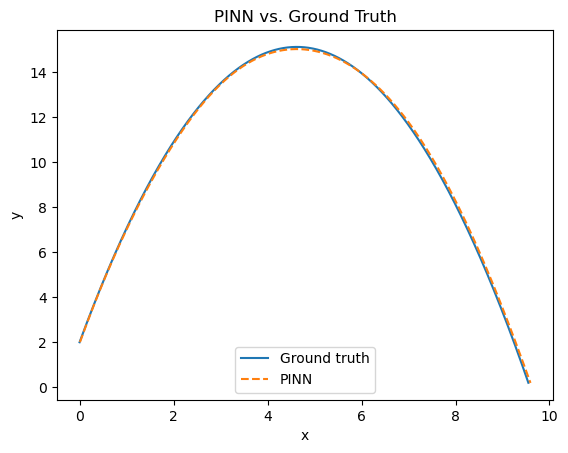

In [7]:
# plot & mse
plt.plot(labels_pde_x, labels_pde_y, label = "Ground truth"); plt.plot(x, y, '--', label = "PINN");
plt.legend(loc='lower center'); plt.title('PINN vs. Ground Truth'); plt.xlabel('x'); plt.ylabel('y');
jnp.mean((jnp.hstack([labels_pde_x, labels_pde_y]) - jnp.hstack([x, y]))**2)

Write PINN prediction & ground truth to file

In [8]:
#np.save('projectile_cma_60s', (x, y, labels_pde_x, labels_pde_y))